<a href="https://colab.research.google.com/github/MrezaFd/Tugas-Besar-ML-059-055-/blob/main/Tugas_5_(3model)convolutional_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import files #import lib
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rezafdz","key":"fd16295d7b817e274541292110c8f784"}'}

In [3]:
!mkdir -p ~/.kaggle #membuat directory bernama kaggle 
!cp kaggle.json ~/.kaggle/ #copy file kaggle.json upload tadi ke directory baru
!chmod 600 ~/.kaggle/kaggle.json #berikan izin untuk file kaggle.jsonv

In [4]:
#Unduh dataset
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 98% 317M/325M [00:04<00:00, 83.4MB/s]
100% 325M/325M [00:04<00:00, 69.9MB/s]


In [5]:
from zipfile import ZipFile
file_name = "skin-cancer-malignant-vs-benign.zip"

with ZipFile(file_name,'r') as zip :
  zip.extractall()
  print('Berhasil')

Berhasil


In [6]:
!mkdir a

In [7]:
!mv -t a test train

In [8]:
# Definisikan path untuk data train dan data validation
import os
base_dir = '/content/a'


train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

In [9]:
import cv2
import numpy as np

# Gather data train
train_data = []
train_label = []
for r, d, f in os.walk(train_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            train_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            train_label.append(label)

train_data = np.array(train_data)
train_label = np.array(train_label)

In [10]:
# Gather data validation
val_data = []
val_label = []
for r, d, f in os.walk(validation_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            val_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            val_label.append(label)

val_data = np.array(val_data)
val_label = np.array(val_label)

<h3>Data Preprocessing</h3>

In [11]:
# Tampilkan shape dari data train dan data validation
print("Train Data = ", train_data.shape)
print("Train Label = ", train_label.shape)
print("Validation Data = ", val_data.shape)
print("Validation Label = ", val_label.shape)

Train Data =  (2637, 150, 150, 3)
Train Label =  (2637,)
Validation Data =  (660, 150, 150, 3)
Validation Label =  (660,)


In [12]:
# Normalisasi dataset
print("Data sebelum di-normalisasi ", train_data[0][0][0])

x_train = train_data.astype('float32') / 255.0
x_val = val_data.astype('float32') / 255.0
print("Data setelah di-normalisasi ", x_train[0][0][0])

Data sebelum di-normalisasi  [184 171 248]
Data setelah di-normalisasi  [0.72156864 0.67058825 0.972549  ]


In [13]:
# Transformasi label encoder
from sklearn.preprocessing import LabelEncoder

print("Label sebelum di-encoder ", train_label[995:2005])

lb = LabelEncoder()
y_train = lb.fit_transform(train_label)
y_val = lb.fit_transform(val_label)

print("Label setelah di-encoder ", y_train[995:2005])

Label sebelum di-encoder  ['benign' 'benign' 'benign' ... 'malignant' 'malignant' 'malignant']
Label setelah di-encoder  [0 0 0 ... 1 1 1]


<h3>Definisikan Model 1</h3>

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import time

In [15]:
# Feature Extraction Layer
model = Sequential()

model.add(InputLayer(input_shape=[150,150,3]))
model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Flatten())
# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [16]:
# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 19, 64)       0

In [17]:
# Compile model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.001), 
              loss='binary_crossentropy', 
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
H = model.fit(x_train, y_train, batch_size=20, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
132/132 [==============================] - 17s 41ms/step - loss: 0.5511 - acc: 0.6928 - val_loss: 0.4173 - val_acc: 0.7773
Epoch 2/100
132/132 [==============================] - 4s 30ms/step - loss: 0.4277 - acc: 0.7876 - val_loss: 0.3894 - val_acc: 0.8000
Epoch 3/100
132/132 [==============================] - 3s 24ms/step - loss: 0.3823 - acc: 0.8104 - val_loss: 0.3708 - val_acc: 0.7955
Epoch 4/100
132/132 [==============================] - 3s 24ms/step - loss: 0.3708 - acc: 0.8184 - val_loss: 0.3568 - val_acc: 0.8197
Epoch 5/100
132/132 [==============================] - 3s 24ms/step - loss: 0.3345 - acc: 0.8339 - val_loss: 0.3501 - val_acc: 0.8364
Epoch 6/100
132/132 [==============================] - 3s 24ms/step - loss: 0.3219 - acc: 0.8385 - val_loss: 0.3394 - val_acc: 0.8364
Epoch 7/100
132/132 [==============================] - 3s 24ms/step - loss: 0.2988 - acc: 0.8582 - val_loss: 0.3463 - val_acc: 0.8242
Epoch 8/100
132/132 [==============================] - 3s 24m

EVALUASI MODEL 1


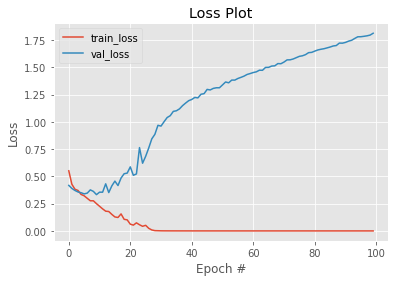

In [19]:

%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

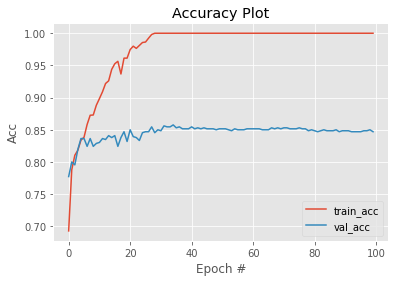

In [20]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import classification_report

target = ['bening']
pred = model.predict(x_val)
labels = (pred > 0.5).astype(np.int)


print(classification_report(y_val, labels))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       360
           1       0.82      0.85      0.83       300

    accuracy                           0.85       660
   macro avg       0.85      0.85      0.85       660
weighted avg       0.85      0.85      0.85       660



MODEL 2

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import time

In [24]:
model2 = Sequential()

model2.add(InputLayer(input_shape=[150,150,3]))
model2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(pool_size=2))
model2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(pool_size=2))
model2.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(pool_size=2))
model2.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(pool_size=2))

model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Flatten())

model2.add(Dense(512, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [37]:
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

In [28]:
# Compile model
from tensorflow.keras.optimizers import Adam

model2.compile(optimizer=Adam(lr=0.001), 
              loss='binary_crossentropy', 
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
H2 = model2.fit(x_train, y_train, batch_size=20, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
132/132 [==============================] - 10s 62ms/step - loss: 0.5651 - acc: 0.7084 - val_loss: 0.6872 - val_acc: 0.7545
Epoch 2/100
132/132 [==============================] - 7s 56ms/step - loss: 0.4969 - acc: 0.7615 - val_loss: 0.6552 - val_acc: 0.6439
Epoch 3/100
132/132 [==============================] - 7s 56ms/step - loss: 0.4794 - acc: 0.7573 - val_loss: 0.4537 - val_acc: 0.7758
Epoch 4/100
132/132 [==============================] - 7s 55ms/step - loss: 0.4787 - acc: 0.7569 - val_loss: 0.5585 - val_acc: 0.6712
Epoch 5/100
132/132 [==============================] - 7s 56ms/step - loss: 0.4561 - acc: 0.7728 - val_loss: 0.4456 - val_acc: 0.7697
Epoch 6/100
132/132 [==============================] - 9s 65ms/step - loss: 0.4230 - acc: 0.7907 - val_loss: 1.1420 - val_acc: 0.5894
Epoch 7/100
132/132 [==============================] - 7s 55ms/step - loss: 0.4076 - acc: 0.7899 - val_loss: 0.6125 - val_acc: 0.7167
Epoch 8/100
132/132 [==============================] - 7s 55m

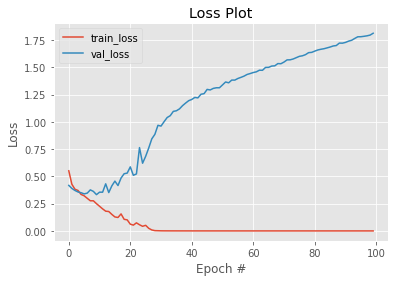

In [30]:

%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

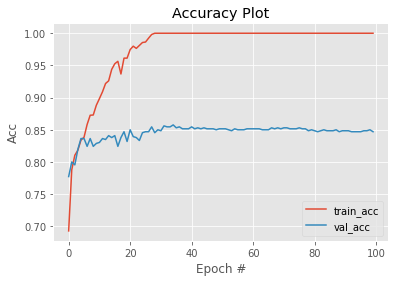

In [31]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H2.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H2.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import classification_report

target = ['bening']
pred = model2.predict(x_val)
labels = (pred > 0.5).astype(np.int)


print(classification_report(y_val, labels))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       360
           1       0.78      0.87      0.82       300

    accuracy                           0.83       660
   macro avg       0.83      0.83      0.83       660
weighted avg       0.83      0.83      0.83       660



MODEL 3

In [34]:
model3 = Sequential()

model3.add(InputLayer(input_shape=[150,150,3]))
model3.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model3.add(MaxPool2D(pool_size=2))
model3.add(BatchNormalization())

model3.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model3.add(MaxPool2D(pool_size=2))
model3.add(BatchNormalization())

model3.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model3.add(MaxPool2D(pool_size=2))
model3.add(BatchNormalization())

model3.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model3.add(MaxPool2D(pool_size=2))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Flatten())

model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

In [38]:
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 74, 74, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                      

In [39]:
# Compile model
from tensorflow.keras.optimizers import Adam

model3.compile(optimizer=Adam(lr=0.001), 
              loss='binary_crossentropy', 
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [40]:
H3 = model3.fit(x_train, y_train, batch_size=20, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
132/132 [==============================] - 9s 61ms/step - loss: 0.8941 - acc: 0.7304 - val_loss: 1.0227 - val_acc: 0.4545
Epoch 2/100
132/132 [==============================] - 8s 58ms/step - loss: 0.5375 - acc: 0.7649 - val_loss: 1.2962 - val_acc: 0.4758
Epoch 3/100
132/132 [==============================] - 8s 60ms/step - loss: 0.4385 - acc: 0.7903 - val_loss: 0.5297 - val_acc: 0.7576
Epoch 4/100
132/132 [==============================] - 10s 73ms/step - loss: 0.4326 - acc: 0.8024 - val_loss: 0.5314 - val_acc: 0.7606
Epoch 5/100
132/132 [==============================] - 9s 65ms/step - loss: 0.4027 - acc: 0.8024 - val_loss: 0.5372 - val_acc: 0.7561
Epoch 6/100
132/132 [==============================] - 9s 65ms/step - loss: 0.3762 - acc: 0.8309 - val_loss: 0.3673 - val_acc: 0.8364
Epoch 7/100
132/132 [==============================] - 8s 64ms/step - loss: 0.3446 - acc: 0.8362 - val_loss: 0.4807 - val_acc: 0.7545
Epoch 8/100
132/132 [==============================] - 8s 60m

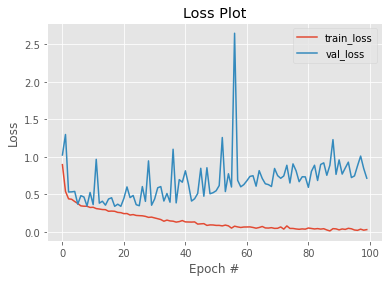

In [41]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H3.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H3.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

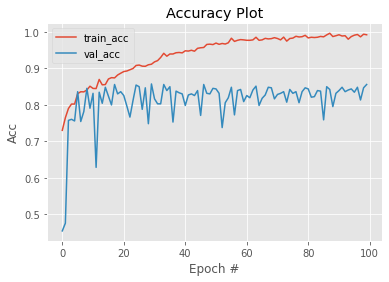

In [42]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H3.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H3.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import classification_report

target = ['bening']
pred = model3.predict(x_val)
labels = (pred > 0.5).astype(np.int)


print(classification_report(y_val, labels))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       360
           1       0.81      0.89      0.85       300

    accuracy                           0.86       660
   macro avg       0.86      0.86      0.86       660
weighted avg       0.86      0.86      0.86       660

